In [1]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact 

# Define the directory containing the sample directories
base_dir = "/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/cellranger_outs/"
filename = 'cellbender_doublet_detection_filtered_feature_bc_matrix.h5'


In [7]:
print(sc.__version__)

1.11.0


In [3]:
adata = sc.read_h5ad(f'/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_147180_cells_250813.h5ad')

# Drop CRPCs
adata = adata[~(adata.obs['type'].isin(['CRPC']))]
adata = adata[~(adata.obs['cell_type'].isin(['Cycling cell']))]

sc.pp.scale(adata,layer='log1p')adata


AnnData object with n_obs × n_vars = 119733 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'log1p'
    obsp: 'connectivities', 'distances'

In [5]:
ctype_order = [
    'Epithelial cell',
    'Fibroblast',
    'Endothelial cell',
    'T cell',
    'B cell',
    'Myeloid cell',
    'Mast cell',
    #'Cycling cell'
    ]

adata.obs['cell_type_treatment'] = adata.obs['type'].astype(str) + ' ' + adata.obs['cell_type'].astype(str)
adata.obs['cell_type_treatment'] = pd.Categorical(adata.obs['cell_type_treatment'],categories=['PC ' + c for c in ctype_order] + ['HSPC ' + c for c in ctype_order])



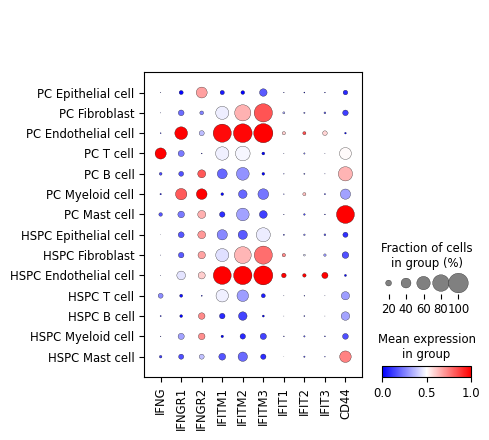

In [6]:
gene_markers = [
    #'CD3E','CD4','CD8A','EPCAM','CD68',
    #'AR', 'ESR1', 'ESR2', 'NR3C1', 'NR3C2', 'PGR',  # Steroid hormone receptors
    #'RARG',
    #'NFKB1','NFKB2','RELA','RELB','REL'
    # Core receptors
    #"RARA", "RARB","RARG", 
    #"RXRA", "RXRB", "RXRG",
    # Classic direct RA targets
    #"CRABP2", "RARRES1", "RARRES3",
    #'FAP','NFKB1','IL1B','TNF','IL6', # Inflammation
    #'CD8B','CD4','CTLA4','PDCD1','CD68','CD163','CD74','B2M' # Immune response genes

    # IFN signaling genes
    'IFNG','IFNGR1','IFNGR2','IFITM1','IFITM2','IFITM3','IFIT1','IFIT2','IFIT3','CD44'
]
#sc.tl.dendrogram(cell_type_treatment,groupby='cell_type')
fig, ax = plt.subplots(figsize=(5,4.5))
sc.pl.dotplot(adata,
    groupby='cell_type_treatment',
    var_names=gene_markers,
    dendrogram=False,
    #use_raw=False,
    layer='log1p',
    standard_scale='var',
    cmap='bwr',
    ax = ax,
    show=False,
    #vmax=2.5
    )

plt.tight_layout()
plt.savefig('/home/ak431480/plots/scs_data_celltype_all_dotplot_IFNg_signaling_genes.pdf',dpi=300)
plt.show()

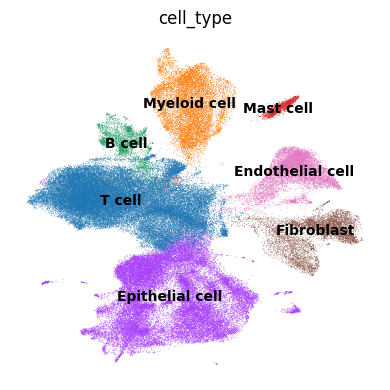

In [7]:
fig, ax= plt.subplots(figsize=(4,4))
sc.pl.umap(adata,color='cell_type',legend_loc='on data',frameon=False,ax=ax,show=False)
plt.tight_layout()
plt.savefig('/home/ak431480/plots/scs_data_celltype_all.png',dpi=300)
plt.show()

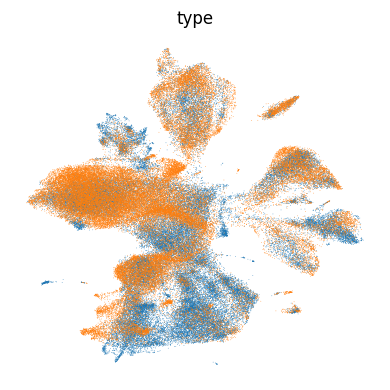

In [8]:
fig, ax= plt.subplots(figsize=(4,4))
sc.pl.umap(adata,color='type',legend_loc=None,frameon=False,ax=ax,show=False)
plt.tight_layout()
plt.savefig('/home/ak431480/plots/scs_data_treatment_all.png',dpi=300)
plt.show()

### Ruscetti IFNg / IFNgR

In [ ]:
signatures_of_interest = ['HALLMARK_INTERFERON_GAMMA_RESPONSE','HALLMARK_TNFA_SIGNALING_VIA_NFKB','HALLMARK_IL6_JAK_STAT3_SIGNALING']

In [8]:
prostate_lineage_signatures_dict = {}
prostate_lineage_signatures = pd.read_excel('/home/ak431480/prostate_lineage_signatures.xlsx',skiprows=1)
for gset in tqdm(signatures_of_interest):
    sig = prostate_lineage_signatures[gset].dropna().tolist()
    sc.tl.score_genes(adata,sig,score_name=gset,layer='log1p',use_raw=False)
    prostate_lineage_signatures_dict[gset] = sig

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:19<00:39, 19.74s/it]

100%|██████████| 3/3 [00:57<00:00, 19.33s/it]


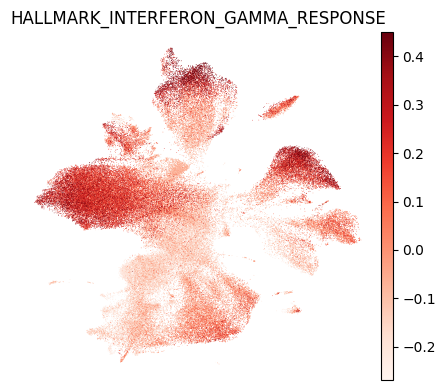

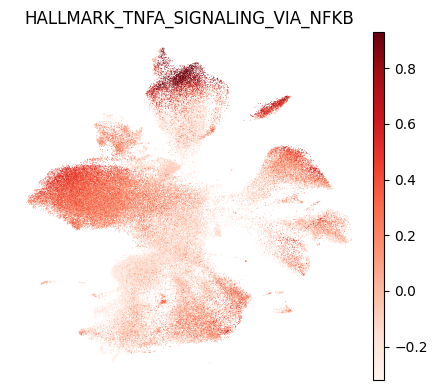

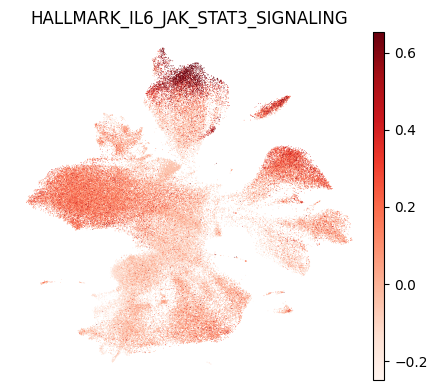

In [12]:
for sig in signatures_of_interest:
    fig, ax= plt.subplots(figsize=(4.5,4))
    sc.pl.umap(adata,color=sig,legend_loc=None,frameon=False,ax=ax,show=False,cmap='Reds',vmin='p1',vmax='p99')
    plt.tight_layout()
    plt.savefig(f'/home/ak431480/plots/scs_data_treatment_all_{sig}.png',dpi=120)
    plt.show()

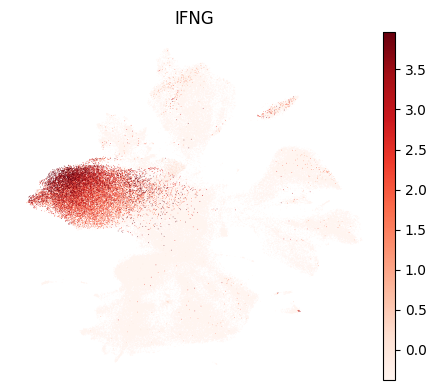

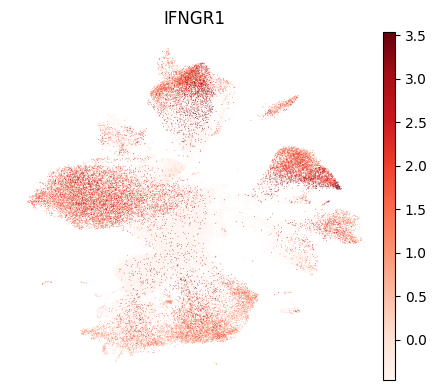

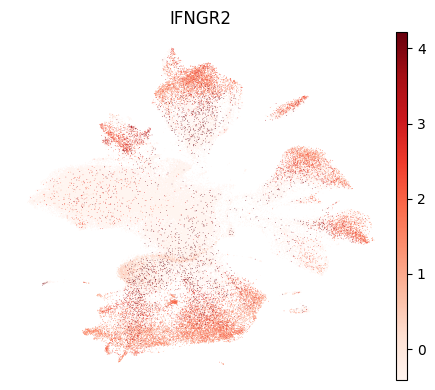

In [13]:
for gene in ['IFNG','IFNGR1','IFNGR2']:
    fig, ax= plt.subplots(figsize=(4.5,4))
    sc.pl.umap(adata,color=gene,legend_loc=None,frameon=False,ax=ax,show=False,cmap='Reds',vmin='p1',vmax='p99',layer='log1p')
    plt.tight_layout()
    plt.savefig(f'/home/ak431480/plots/scs_data_treatment_all_{gene}.png',dpi=120)
    plt.show()

## Fraction of counts coming from different cell types

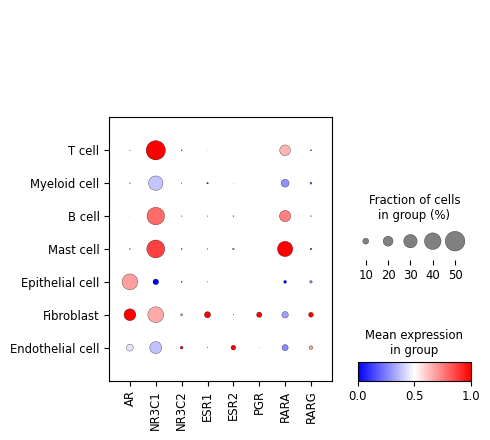

In [9]:
gene_markers = [
    # IFN signaling genes
    'AR','NR3C1','NR3C2','ESR1','ESR2','PGR','RARA','RARG'
]
#sc.tl.dendrogram(cell_type_treatment,groupby='cell_type')
fig, ax = plt.subplots(figsize=(5,4.5))
sc.pl.dotplot(adata[adata.obs['type'] == 'PC'], # HSPC
    groupby='cell_type', 
    var_names=gene_markers,
    dendrogram=False,
    #use_raw=False,
    layer='log1p',
    standard_scale='var',
    cmap='bwr',
    ax = ax,
    show=False,
    #vmax=2.5
    )

plt.tight_layout()
plt.savefig('/home/ak431480/plots/scs_data_celltype_all_dotplot_steroid_receptor_genes.pdf',dpi=300)
plt.show()

In [10]:
adata_raw = adata.raw.to_adata()
adata_raw.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata_raw,target_sum=1e4)

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [72]:
#gene_markers = ['EPCAM','CD3E','AR','NR3C1','NR3C2','ESR1','ESR2','PGR','RARA','RARG']
gene_markers = ['AR','NR3C1','ESR1']

# Extract expression values (use raw counts or a suitable layer, not log1p)
# Assuming "counts" layer has untransformed counts
#expr = adata[:, gene_markers].to_df(layer="log1p")
expr = pd.DataFrame(adata_raw[:,gene_markers].X.todense(),index=adata_raw.obs_names,columns=gene_markers)
meta = adata.obs[['cell_type','type']]

# Combine expression with metadata
df = expr.join(meta)

# --- 2) Long format and aggregate counts per (gene, type, cell_type) ---

df_long = df.reset_index().melt(id_vars=['index','cell_type','type'],
                                value_vars=gene_markers,
                                var_name='gene',
                                value_name='counts')
df_long = df_long.rename(columns={'index':'obs_name'})

# --- Compute global cell_type distribution (across all cells) ---
global_ct_counts = df_long.drop_duplicates('obs_name').groupby('cell_type').size()
global_ct_frac = global_ct_counts / global_ct_counts.sum()

# --- Compute per-type cell_type distribution ---
type_ct_counts = (df_long.drop_duplicates('obs_name')
                           .groupby(['type','cell_type'])
                           .size()
                           .unstack(fill_value=0))

type_ct_frac = type_ct_counts.div(type_ct_counts.sum(axis=1), axis=0)

# --- Reweighting factors so each type matches the global distribution ---
# factor = global fraction / within-type fraction
scaling = global_ct_frac.to_frame('global_frac').join(type_ct_frac.T, how='outer').fillna(0)

# turn into dictionary: scaling[(type, cell_type)]
scaling_factors = {}
for ct in global_ct_frac.index:
    for tp in type_ct_frac.index:
        frac_tp = type_ct_frac.loc[tp, ct] if ct in type_ct_frac.columns else 0
        frac_gl = global_ct_frac.loc[ct]
        if frac_tp > 0:
            scaling_factors[(tp, ct)] = frac_gl / frac_tp
        else:
            scaling_factors[(tp, ct)] = 0.0

# --- Apply scaling to counts ---
df_long['scaled_counts'] = df_long.apply(
    lambda r: r['counts'] * scaling_factors.get((r['type'], r['cell_type']), 0),
    axis=1
)

# --- Aggregate scaled counts per (gene, type, cell_type) ---
agg = (df_long
       .groupby(['gene','type','cell_type'], observed=True)['scaled_counts']
       .sum()
       .reset_index()
       .rename(columns={'scaled_counts':'counts'}))

# Calculate the percentage of cells expressing  these genes
pct_expressing_dict = ((df[gene_markers] != 0).sum()/len(df)*100).to_dict()

/tmp/ipykernel_272312/2992050052.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  global_ct_counts = df_long.drop_duplicates('obs_name').groupby('cell_type').size()
/tmp/ipykernel_272312/2992050052.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['type','cell_type'])


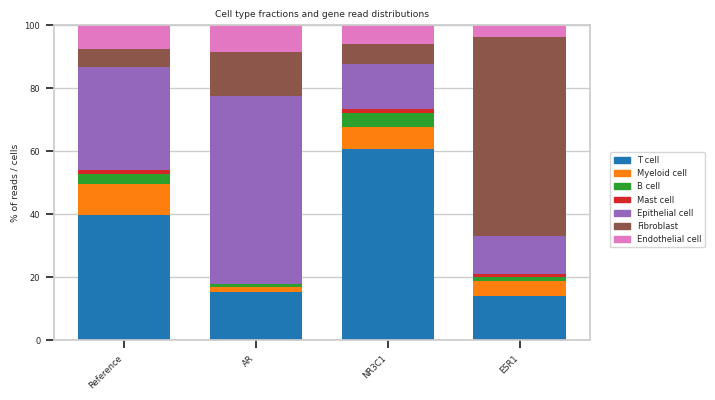

In [86]:
import numpy as np
import matplotlib.patches as mpatches

# --- plotting (reference + one bar per gene), normalized to 100% ---
all_cell_types = list(counts_table.columns)
bar_labels = ['Reference'] + gene_markers
x = np.arange(len(bar_labels))

# build data_bars: first ref_frac (Series), then each gene (Series) normalized to 100
data_bars = [ref_frac]  # ref_frac must be aligned to all_cell_types
for gene in gene_markers:
    try:
        gene_df = counts_table.loc[gene].sum(axis=0)
    except KeyError:
        gene_df = pd.Series(0, index=all_cell_types)
    gene_df = gene_df.reindex(all_cell_types).fillna(0)
    total = gene_df.sum()
    if total > 0:
        gene_df = (gene_df / total) * 100
    data_bars.append(gene_df)

# colors
palette = sns.color_palette(None, n_colors=len(all_cell_types))

fig, ax = plt.subplots(1, 1, figsize=(1.5*(len(bar_labels)), 4))
palette = sns.color_palette(None, n_colors=len(all_cell_types))
sns.set_theme(style='whitegrid', palette=palette, font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})


# draw stacked bars
bottoms = np.zeros(len(bar_labels))
for i, ct in enumerate(all_cell_types):
    vals = np.array([d.iloc[i] for d in data_bars])  # values for this cell_type across all bars
    ax.bar(x, vals, bottom=bottoms, width=0.7, color=palette[i], linewidth=0)
    bottoms += vals

# formatting
ax.set_xticks(x)
ax.set_xticklabels(bar_labels, rotation=45, ha='right')
ax.set_ylim(0, 100)
ax.set_ylabel('% of reads / cells')
ax.set_title('Cell type fractions and gene read distributions')

# explicit legend (one patch per cell_type)
legend_handles = [mpatches.Patch(color=palette[i], label=ct) for i, ct in enumerate(all_cell_types)]
fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.01, 0.5))

plt.tight_layout()
plt.savefig('/home/ak431480/plots/single_cell_barplot_cells_expressing.pdf')
plt.show()


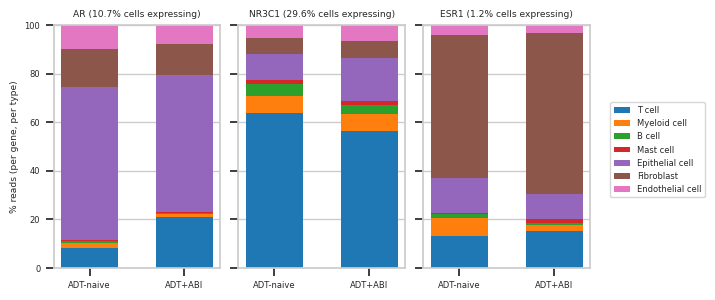

In [76]:
# Alternatively split by treatment, normalizing them by 

# --- 3) Pivot to get counts table (multiindex: gene,type rows; columns: cell_type) ---
pivot_counts = agg.pivot_table(index=['gene','type'],
                               columns='cell_type',
                               values='counts',
                               fill_value=0)

# convert to percentages per (gene,type) row
row_sums = pivot_counts.sum(axis=1)
# avoid division by zero
pct = pivot_counts.div(row_sums.replace(0, np.nan), axis=0).fillna(0) * 100

# quick check: every (gene,type) should sum to ~100
check = pct.sum(axis=1).round(6).unique()

# --- 4) Plot stacked bars (one panel per gene), PC first then HSPC ---
types_order = ['PC','HSPC']   # enforces PC then HSPC; if a type is missing it will be filled with 0
all_cell_types = list(pct.columns)      # all cell_type categories
n_genes = len(gene_markers)
fig, axes = plt.subplots(1, n_genes, figsize=(2*n_genes, 3), sharey=True)

if n_genes == 1:
    axes = [axes]

palette = sns.color_palette(None, n_colors=len(all_cell_types))
sns.set_theme(style='whitegrid', palette=palette, font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})


for ax, gene in zip(axes, gene_markers):
    # select rows for this gene -> DataFrame indexed by 'type' with columns cell_types
    try:
        gene_df = pct.loc[gene]   # DataFrame indexed by type
    except KeyError:
        # gene not present
        gene_df = pd.DataFrame(0, index=types_order, columns=all_cell_types)

    # ensure types order and fill missing
    gene_df = gene_df.reindex(types_order).fillna(0)[all_cell_types]

    x = np.arange(len(types_order))
    bottoms = np.zeros(len(types_order))

    for i, ct in enumerate(all_cell_types):
        vals = gene_df[ct].values
        ax.bar(x, vals, bottom=bottoms, width=0.6, label=ct if ax is axes[0] else "", alpha=1.0,linewidth=0)
        bottoms = bottoms + vals

    ax.set_xticks(x)
    ax.set_xticklabels(['ADT-naive','ADT+ABI'])
    ax.set_ylim(0, 100)
    ax.set_title(f'{gene} ({pct_expressing_dict[gene]:.1f}% cells expressing)')
    ax.set_xlabel("")
    if ax is axes[0]:
        ax.set_ylabel('% reads (per gene, per type)')

# legend outside
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.savefig('/home/ak431480/plots/single_cell_barplot_cells_expressing.pdf')
plt.show()